## importing packages
$s[k]$

In [1]:
import sys
import threading
import atexit
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import time
from PyQt4 import QtGui, uic, QtCore
from matplotlib.backends.backend_qt4agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt4agg import NavigationToolbar2QT as NavigationToolbar

In [3]:
chunksize = 2048
tempo_res = 32  # r_coeff resolution, needs to be a factor of chunksize
tempo_num = int(chunksize / tempo_res)
iteration = 0  # for counting, if needed
noise = np.array(np.round(200000 * np.random.randn(chunksize)),dtype="int32")  # to desensitise onset detection
sampling_rate = 44100
notes_dict = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

# run this once only
entry_start_number = 0

# holding variables
signal_frame_pp0 = [0] * chunksize
signal_frame_pp1 = [0] * chunksize
signal_frame_pp2 = [0] * chunksize
signal_frame_pp3 = [0] * chunksize
energy_frame_pp0 = [0] * chunksize
energy_frame_pp1 = [0] * chunksize
energy_frame_pp2 = [0] * chunksize
energy_frame_pp3 = [0] * chunksize
rcoeff_frame_pp1 = [0.0] * int(tempo_res)
rcoeff_frame_pp2 = [0.0] * int(tempo_res)
rcoeff_frame_pp3 = [0.0] * int(tempo_res)

note_detected = False
ffreq = 0.0
signal_to_show = [0] * (chunksize * 2)
signal_to_ayse = [0] * (chunksize)
shift = 0.0
signal_frame_pp1[1] = 1
energy_frame_pp2[1] = 1

## The following code is inside handle_new_data

Obtaining signal

In [4]:
'''
# print str(time.time() - start_time) + "  " + str(time.time() - prev_time) + \
# " gets the latest frames"
# prev_time = time.time()
signal_frames = mic.get_frames()
'''

import os
import soundfile as sf
# read file
fileDir = os.path.dirname(os.path.realpath('__file__'))
file_name = os.path.join(fileDir, '../sounds/marsh mono.wav')
file_name = os.path.abspath(os.path.realpath(file_name))
ref, sample_rate = sf.read(file_name)

t_start = 0.65
t_end = 29.0
signal = ref[int(t_start * 44100): int(t_end * 44100), 0]
signal_length = chunksize

# add noise so that silent parts will not give ambiguous values
# signal = np.add(signal, 0.001*np.random.randn(len(signal)))
# sd.play(signal, sample_rate)



# Loop the following

4096


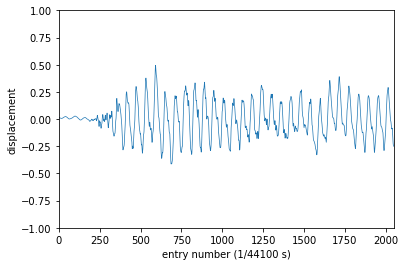

In [11]:
signal_frame_pp0 = np.array(np.array(signal[entry_start_number:entry_start_number+chunksize])*32768, dtype="int32")
entry_start_number = entry_start_number + chunksize
print entry_start_number

plt.plot(np.array(signal_frame_pp0, dtype=float)/32768, lw=0.7)
plt.xlabel("entry number (1/44100 s)")
plt.ylabel("displacement")
ax = plt.gca() 
ax.set_xlim([0, chunksize])
ax.set_ylim([-1, 1])
plt.show()

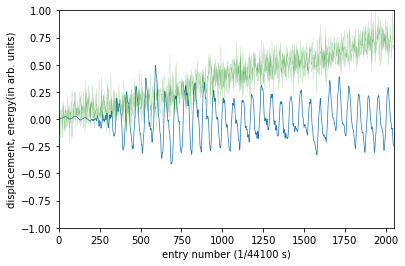

In [12]:
# print str(time.time() - start_time) + "  " + str(time.time() - prev_time) + \
# " energy calculations"  # 0.01s
# prev_time = time.time()
# to calculate the rectangular window for every sample
# numpy operations are more efficient than using python loops
# the size of the rectangular window is one chunksize
# convolution can be considered
energy_frame_pp0 = np.full(chunksize, sum(np.absolute(signal_frame_pp2)), dtype="int32")
to_cumsum = np.add(np.absolute(signal_frame_pp1), -np.absolute(signal_frame_pp2))
cumsum = np.cumsum(to_cumsum)
energy_frame_pp0[1:] = np.add(energy_frame_pp0[1:], cumsum[:-1])
energy_frame_pp0 = np.add(energy_frame_pp0, noise)
# energy_frame_pp0 = np.add(energy_frame_pp0, [100]*2048)

plt.plot(np.array(signal_frame_pp0, dtype=float)/32768, lw=0.7)
plt.plot(np.array(energy_frame_pp0, dtype=float)/np.max(energy_frame_pp0), lw=0.1, color='g')
plt.xlabel("entry number (1/44100 s)")
plt.ylabel("displacement, energy(in arb. units)")
ax = plt.gca() 
ax.set_xlim([0, chunksize])
ax.set_ylim([-1, 1])
plt.show()

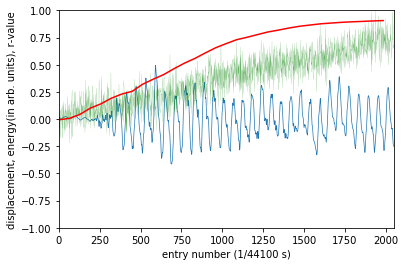

In [13]:
# print str(time.time() - start_time) + "  " + str(time.time() - prev_time) + \
# " r_coeff calculations"
# prev_time = time.time()
# calculating pearson correlation coefficient at 2048/32 samples
# to determine exact time of onset
# could not think of any way this could be parallelised
energy_arg = np.concatenate((energy_frame_pp1, energy_frame_pp0))
# energy_arg = np.concatenate((energy_frame_pp1[i*tempo_num:],
#                              energy_frame_pp0[:-(tempo_res-i)*tempo_num]))
for i in range(tempo_res):
    rcoeff_frame_pp1[i] = np.corrcoef(energy_arg[i * tempo_num:(i * tempo_num + chunksize)],
                                      np.arange(chunksize))[0, 1]
    
plt.plot(np.array(signal_frame_pp0, dtype=float)/32768, lw=0.7)
plt.plot(np.array(energy_frame_pp0, dtype=float)/np.max(energy_frame_pp0), lw=0.1, color='g')
plt.plot(np.arange(0,chunksize,tempo_num), rcoeff_frame_pp1, color='r')
plt.xlabel("entry number (1/44100 s)")
plt.ylabel("displacement, energy(in arb. units), r-value")
ax = plt.gca() 
ax.set_xlim([0, chunksize])
ax.set_ylim([-1, 1])
plt.show()

## Harmonic Product Spectrum
Explained in another ipython file

In [14]:
# print str(time.time() - start_time) + "  " + str(time.time() - prev_time) + \
# " detecting new note"
# prev_time = time.time()
rcoeff_arg = np.concatenate((rcoeff_frame_pp2, rcoeff_frame_pp1))
# we need the previous rcoeff frame to determine onset

# finding the onset, any way not to loop?
for i in range(tempo_res, 0, -1):
    # if rcoeff_arg[-i] > 0.80 and all(i < 0.80 for i in rcoeff_arg[-i-5:-i]):
    if rcoeff_arg[-i] > 0.80 and np.max(rcoeff_arg[-i - 31:-i]) < 0.80:
        # to determine onset  - where the rcoeff graph crosses 0.80,
        # 31 entries cooldown - check that previous entries do not have cooldown
        # print i
        # print rcoeff_arg[-i]
        # print np.around(rcoeff_arg, 2)

        # print str(time.time() - start_time) + "  " + str(time.time() - prev_time) + \
        # " note class"
        # prev_time = time.time()
        time_arg = np.concatenate((signal_frame_pp3, signal_frame_pp2,
                                   signal_frame_pp1, signal_frame_pp0))
        signal_to_show = time_arg[-i * tempo_num - int((2 + shift) * chunksize):
                                  -i * tempo_num - int((0 + shift) * chunksize)]
        signal_to_ayse = time_arg[-i * tempo_num - int((1 + shift) * chunksize):
                                  -i * tempo_num - int((0 + shift) * chunksize)]
        signal_to_deduct = time_arg[-i * tempo_num - int((2 + shift) * chunksize):
                                    -i * tempo_num - int((1 + shift) * chunksize)]
        # Consider whether should a window be applied

        spectrum = np.absolute(np.fft.fft(signal_to_ayse))

        spectrum_to_deduct = np.absolute(np.fft.fft(signal_to_deduct))
        to_subtract = False  # take the spectral difference between the current and previous chunk
        if to_subtract:
            spectrum = np.clip(np.add(spectrum, -1 * np.array(spectrum_to_deduct)), 0, 100000000)
            # consider the effectiveness of taking the difference

        # following is the hps algorithm
        spectrum[:12] = 0.0  # anything below middle C is muted
        spectrum[1024:] = 0.0  # mute second half of spectrum, lazy to change code

        scale1 = [0.0] * (2048 * 6)
        scale2 = [0.0] * (2048 * 6)
        scale3 = [0.0] * (2048 * 6)

        # upsampling the original scale spectrum, 6 for 1
        scale1_f1 = np.convolve(spectrum, [5.0 / 6.0, 1.0 / 6.0])[1:]
        scale1_f2 = np.convolve(spectrum, [4.0 / 6.0, 2.0 / 6.0])[1:]
        scale1_f3 = np.convolve(spectrum, [3.0 / 6.0, 3.0 / 6.0])[1:]
        scale1_f4 = np.convolve(spectrum, [2.0 / 6.0, 4.0 / 6.0])[1:]
        scale1_f5 = np.convolve(spectrum, [1.0 / 6.0, 5.0 / 6.0])[1:]
        scale1[::6] = spectrum
        scale1[1::6] = scale1_f5
        scale1[2::6] = scale1_f4
        scale1[3::6] = scale1_f3
        scale1[4::6] = scale1_f2
        scale1[5::6] = scale1_f1
        # downsampling from the 6 for 1 upsample
        scale2[:2048 * 3] = scale1[::2]
        scale3[:2048 * 2] = scale1[::3]
        hps = np.prod((scale1, scale2, scale3), axis=0)  # the "product" in harmonic product spectrum
        hps_max = np.argmax(hps)  # determine the location of the peak of hps result
        # calculate the corresponding frequency of the peak
        ffreq = hps_max * 44100.0 / (2048.0 * 6.0)  # sampling rate / (chunksize * upsampling value)

        spectrum = np.array(spectrum[:int(0.5 * chunksize) + 1])  # to be plotted

        if hps_max < 5:
            print "low ffreq"  # should not be possible - just investigating
            break

        # TODO: add some weights, adapt spread based on how high ffreq is
        total_energy = np.sum(scale1)
        total_energy_due_to_ffreq = np.sum(scale1[::hps_max]) \
                                    + np.sum(scale1[1::hps_max]) + np.sum(scale1[:hps_max - 1:hps_max]) \
            # + np.sum(scale1[2::hps_max]) + np.sum(scale1[:hps_max - 2:hps_max]) \
        # + np.sum(scale1[3::hps_max]) + np.sum(scale1[:hps_max - 3:hps_max]) \
        # + np.sum(scale1[4::hps_max]) + np.sum(scale1[:hps_max - 4:hps_max]) \
        # + np.sum(scale1[5::hps_max]) + np.sum(scale1[:hps_max - 5:hps_max]) \
        # + np.sum(scale1[6::hps_max]) + np.sum(scale1[:hps_max - 6:hps_max])

        portion_of_energy = (total_energy_due_to_ffreq / total_energy) * 21

        if portion_of_energy > 1:
            # printing note in solfage form
            note_no = -3 + (np.log2(ffreq) - np.log2(220.0)) * 12.0  # take logarithm and find note
            note_no_rounded = np.round(note_no)  # round off to nearest note
            note_no_difference = note_no - note_no_rounded
            octave_no = 4 + int(note_no_rounded // 12)
            solfate_no = int(note_no_rounded) % 12
            note = str(notes_dict[solfate_no]) + str(octave_no)

            print ("{:.2f}Hz({:02}) {:.2f}, {:3s} {:+.2f} at {:.3f}s"
                   .format(ffreq, int(note_no_rounded), portion_of_energy, note, note_no_difference,
                           t_start + i*2048./44100.))
            note_detected = True
        else:
            print("inharmonic sound ({:.2f}) detected at {:.3f}s"
                  .format(portion_of_energy, t_start + i*2048./44100.))

753.66Hz(18) 1.01, F#5 +0.32 at 1.207s


If a note is detected, make changes onto the graph.

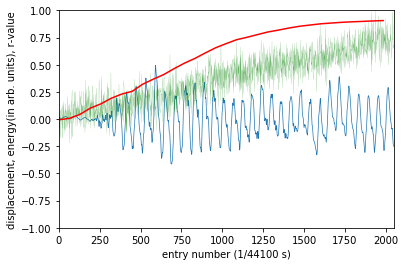

In [15]:
plt.plot(np.array(signal_frame_pp0, dtype=float)/32768, lw=0.7)
plt.plot(np.array(energy_frame_pp0, dtype=float)/np.max(energy_frame_pp0), lw=0.1, color='g')
plt.plot(np.arange(0,chunksize,tempo_num), rcoeff_frame_pp1, color='r')
plt.xlabel("entry number (1/44100 s)")
plt.ylabel("displacement, energy(in arb. units), r-value")
ax = plt.gca() 
ax.set_xlim([0, chunksize])
ax.set_ylim([-1, 1])
plt.show()

## Moving forward to the next frame

In [10]:
# print str(time.time() - start_time) + "  " + str(time.time() - prev_time) + \
# " storing for recursion"
# prev_time = time.time()
signal_frame_pp3 = signal_frame_pp2[:]
signal_frame_pp2 = signal_frame_pp1[:]
signal_frame_pp1 = signal_frame_pp0[:]
energy_frame_pp1 = energy_frame_pp0[:]
rcoeff_frame_pp2 = rcoeff_frame_pp1[:]